In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

2025-11-03 12:25:17.708724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762172717.913570      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762172717.972881      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_SIZE = (300, 300)
BATCH_SIZE = 32
EPOCHS = 30
DATA_DIR = "/kaggle/input/rajasthan-dataset/Rajasthan_Landmark_dataset - Copy/Rajasthan_Landmark_dataset - Copy" 

In [3]:
from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    brightness_range=[0.8, 1.2],
)

train_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)

NUM_CLASSES = len(train_gen.class_indices)
print(f"Detected {NUM_CLASSES} landmark classes")


Found 6248 images belonging to 49 classes.
Found 1562 images belonging to 49 classes.
Detected 49 landmark classes


In [4]:
import numpy as np
labels = train_gen.classes
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))


{0: 80, 1: 144, 2: 144, 3: 80, 4: 80, 5: 80, 6: 144, 7: 80, 8: 144, 9: 144, 10: 144, 11: 80, 12: 144, 13: 144, 14: 144, 15: 144, 16: 80, 17: 144, 18: 144, 19: 144, 20: 144, 21: 144, 22: 144, 23: 80, 24: 80, 25: 144, 26: 144, 27: 80, 28: 80, 29: 80, 30: 144, 31: 144, 32: 144, 33: 144, 34: 80, 35: 144, 36: 144, 37: 80, 38: 144, 39: 80, 40: 144, 41: 80, 42: 144, 43: 80, 44: 200, 45: 200, 46: 200, 47: 200, 48: 200}


In [7]:
BEST_MODEL_PATH = "best_model.keras"
LAST_MODEL_PATH = "last_model.keras"
BEST_MODEL_PATH_fin = "best_model_fin.keras"
LAST_MODEL_PATH_fin = "last_model_fin.keras"


In [5]:
from sklearn.utils.class_weight import compute_class_weight

labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))

In [26]:

# =====================================================
# MODEL SETUP
# =====================================================
def build_model(num_classes):
    base = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
    base.trainable = False  # freeze base for initial training
    
    x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base.input, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_acc')]
    )
    return model


# =====================================================
# LOAD OR BUILD MODEL
# =====================================================
if os.path.exists(LAST_MODEL_PATH):
    print(f"Resuming training from checkpoint: {LAST_MODEL_PATH}")
    model = tf.keras.models.load_model(LAST_MODEL_PATH)
else:
    print("Starting new model training...")
    model = build_model(NUM_CLASSES)

# =====================================================
# CALLBACKS
# =====================================================
callbacks = [
    ModelCheckpoint(BEST_MODEL_PATH, monitor='val_accuracy', save_best_only=True, mode='max'),
    ModelCheckpoint(LAST_MODEL_PATH, monitor='val_accuracy', save_best_only=False),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
]


Resuming training from checkpoint: last_model.keras


In [14]:

# =====================================================
# TRAIN (Stage 1)
# =====================================================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/30


I0000 00:00:1762158359.862927     115 service.cc:148] XLA service 0x7f2e600033a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762158359.863562     115 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762158359.863583     115 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762158362.730491     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/196 ━━━━━━━━━━━━━━━━━━━━ 2:24:24 44s/step - accuracy: 0.0000e+00 - loss: 4.0866 - top3_acc: 0.1250

I0000 00:00:1762158380.237895     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


196/196 ━━━━━━━━━━━━━━━━━━━━ 192s 757ms/step - accuracy: 0.3348 - loss: 2.9508 - top3_acc: 0.4969 - val_accuracy: 0.7894 - val_loss: 1.1826 - val_top3_acc: 0.9193 - learning_rate: 0.0010
Epoch 2/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 53s 269ms/step - accuracy: 0.8025 - loss: 1.1104 - top3_acc: 0.9173 - val_accuracy: 0.8854 - val_loss: 0.6889 - val_top3_acc: 0.9680 - learning_rate: 0.0010
Epoch 3/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 53s 271ms/step - accuracy: 0.8811 - loss: 0.6890 - top3_acc: 0.9598 - val_accuracy: 0.9149 - val_loss: 0.4988 - val_top3_acc: 0.9782 - learning_rate: 0.0010
Epoch 4/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 53s 270ms/step - accuracy: 0.9022 - loss: 0.5170 - top3_acc: 0.9769 - val_accuracy: 0.9373 - val_loss: 0.3897 - val_top3_acc: 0.9827 - learning_rate: 0.0010
Epoch 5/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 51s 261ms/step - accuracy: 0.9285 - loss: 0.4120 - top3_acc: 0.9837 - val_accuracy: 0.9481 - val_loss: 0.3239 - val_top3_acc: 0.9885 - learning_rate: 0.0010
Epoch 6/30
196/196 ━━━━━━

In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, type(layer))


In [28]:
# =====================================================
# FINE-TUNE (Stage 2)
# =====================================================
print("\nUnfreezing deeper layers for fine-tuning...")
for layer in base_model:
    layer.trainable = True

# Optional: freeze first ~300 layers to prevent catastrophic forgetting
if hasattr(model, 'layers'):
    count = 0
    for layer in model.layers:
        count += 1
        if count < 300:
            layer.trainable = False

# Recompile with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_acc')]
)

callbacks2 = [
    ModelCheckpoint(BEST_MODEL_PATH_fin, monitor='val_accuracy', save_best_only=True, mode='max'),
    ModelCheckpoint(LAST_MODEL_PATH_fin, monitor='val_accuracy', save_best_only=False),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
]



Unfreezing deeper layers for fine-tuning...


In [29]:

fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks2
)

Epoch 1/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 126s 445ms/step - accuracy: 0.9853 - loss: 0.0586 - top3_acc: 0.9996 - val_accuracy: 0.9846 - val_loss: 0.0679 - val_top3_acc: 0.9981 - learning_rate: 1.0000e-05
Epoch 2/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 52s 265ms/step - accuracy: 0.9854 - loss: 0.0607 - top3_acc: 0.9993 - val_accuracy: 0.9802 - val_loss: 0.0723 - val_top3_acc: 0.9968 - learning_rate: 1.0000e-05
Epoch 3/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 53s 268ms/step - accuracy: 0.9873 - loss: 0.0563 - top3_acc: 0.9993 - val_accuracy: 0.9827 - val_loss: 0.0715 - val_top3_acc: 0.9968 - learning_rate: 1.0000e-05
Epoch 4/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 50s 257ms/step - accuracy: 0.9922 - loss: 0.0493 - top3_acc: 0.9993 - val_accuracy: 0.9846 - val_loss: 0.0682 - val_top3_acc: 0.9981 - learning_rate: 1.0000e-05
Epoch 5/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 52s 263ms/step - accuracy: 0.9889 - loss: 0.0563 - top3_acc: 1.0000 - val_accuracy: 0.9846 - val_loss: 0.0685 - val_top3_acc: 0.9974 - learning_rate: 3.000

comparing models

In [6]:
# =========================================================
# Load both models
# =========================================================
base_model = tf.keras.models.load_model("/kaggle/input/rajasthan-landmark-detection-pret/keras/default/1/best_model_fin.keras", compile=False)
fine_tuned_model = tf.keras.models.load_model("/kaggle/input/rajasthan-landmark-detection-pret/keras/default/1/fine_tuned_final.keras", compile=False)

I0000 00:00:1762172771.282403      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762172771.283049      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:
# Recompile both (so metrics are tracked)
for m in [base_model, fine_tuned_model]:
    m.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3_acc")]
    )


In [8]:

# =========================================================
# Evaluate both models on validation set
# =========================================================
base_eval = base_model.evaluate(val_gen, verbose=1)
fine_eval = fine_tuned_model.evaluate(val_gen, verbose=1)

print("\n📊 MODEL PERFORMANCE COMPARISON")
print("-" * 50)
print(f"Base Model  ->  Val Accuracy: {base_eval[1]*100:.2f}%, Top-3: {base_eval[2]*100:.2f}%")
print(f"Fine-Tuned  ->  Val Accuracy: {fine_eval[1]*100:.2f}%, Top-3: {fine_eval[2]*100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1762172804.783444     114 service.cc:148] XLA service 0x7d28a8004230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762172804.784158     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762172804.784178     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762172805.925868     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/49 ━━━━━━━━━━━━━━━━━━━━ 16:47 21s/step - accuracy: 0.9688 - loss: 0.0784 - top3_acc: 1.0000

I0000 00:00:1762172815.219156     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/49 ━━━━━━━━━━━━━━━━━━━━ 45s 505ms/step - accuracy: 0.9808 - loss: 0.0712 - top3_acc: 0.9971
49/49 ━━━━━━━━━━━━━━━━━━━━ 25s 330ms/step - accuracy: 0.9401 - loss: 0.3176 - top3_acc: 0.9878

📊 MODEL PERFORMANCE COMPARISON
--------------------------------------------------
Base Model  ->  Val Accuracy: 98.27%, Top-3: 99.74%
Fine-Tuned  ->  Val Accuracy: 94.17%, Top-3: 98.78%


In [9]:

# =========================================================
# Generate predictions for confusion matrix & classification report
# =========================================================
val_gen.reset()
y_true = val_gen.classes
y_labels = list(val_gen.class_indices.keys())

In [10]:

# Predict for both models
y_pred_base = np.argmax(base_model.predict(val_gen, verbose=1), axis=1)
y_pred_fine = np.argmax(fine_tuned_model.predict(val_gen, verbose=1), axis=1)

49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 388ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# =========================================================
# Classification Reports
# =========================================================
print("\n📘 Base Model Classification Report:\n")
print(classification_report(y_true, y_pred_base, target_names=y_labels, zero_division=0))

print("\n📗 Fine-Tuned Model Classification Report:\n")
print(classification_report(y_true, y_pred_fine, target_names=y_labels, zero_division=0))


📘 Base Model Classification Report:

                              precision    recall  f1-score   support

           ALWAR_CITY_PALACE       0.00      0.00      0.00        20
              Achalgarh fort       0.03      0.03      0.03        36
          Akshardham, Jaipur       0.00      0.00      0.00        36
                  Alwar fort       0.05      0.05      0.05        20
       Bhandasar Jain Temple       0.00      0.00      0.00        20
               Bhangarh_fort       0.00      0.00      0.00        20
             Bisaldeo Temple       0.00      0.00      0.00        36
            CHITTORGARH_FORT       0.00      0.00      0.00        20
        City Palace (Jaipur)       0.05      0.06      0.05        36
        City Palace, Udaipur       0.00      0.00      0.00        36
             Dilwara Temples       0.00      0.00      0.00        36
           FATEH_JUNG_GUMBAD       0.00      0.00      0.00        20
                Gadisar Lake       0.00      0.00  

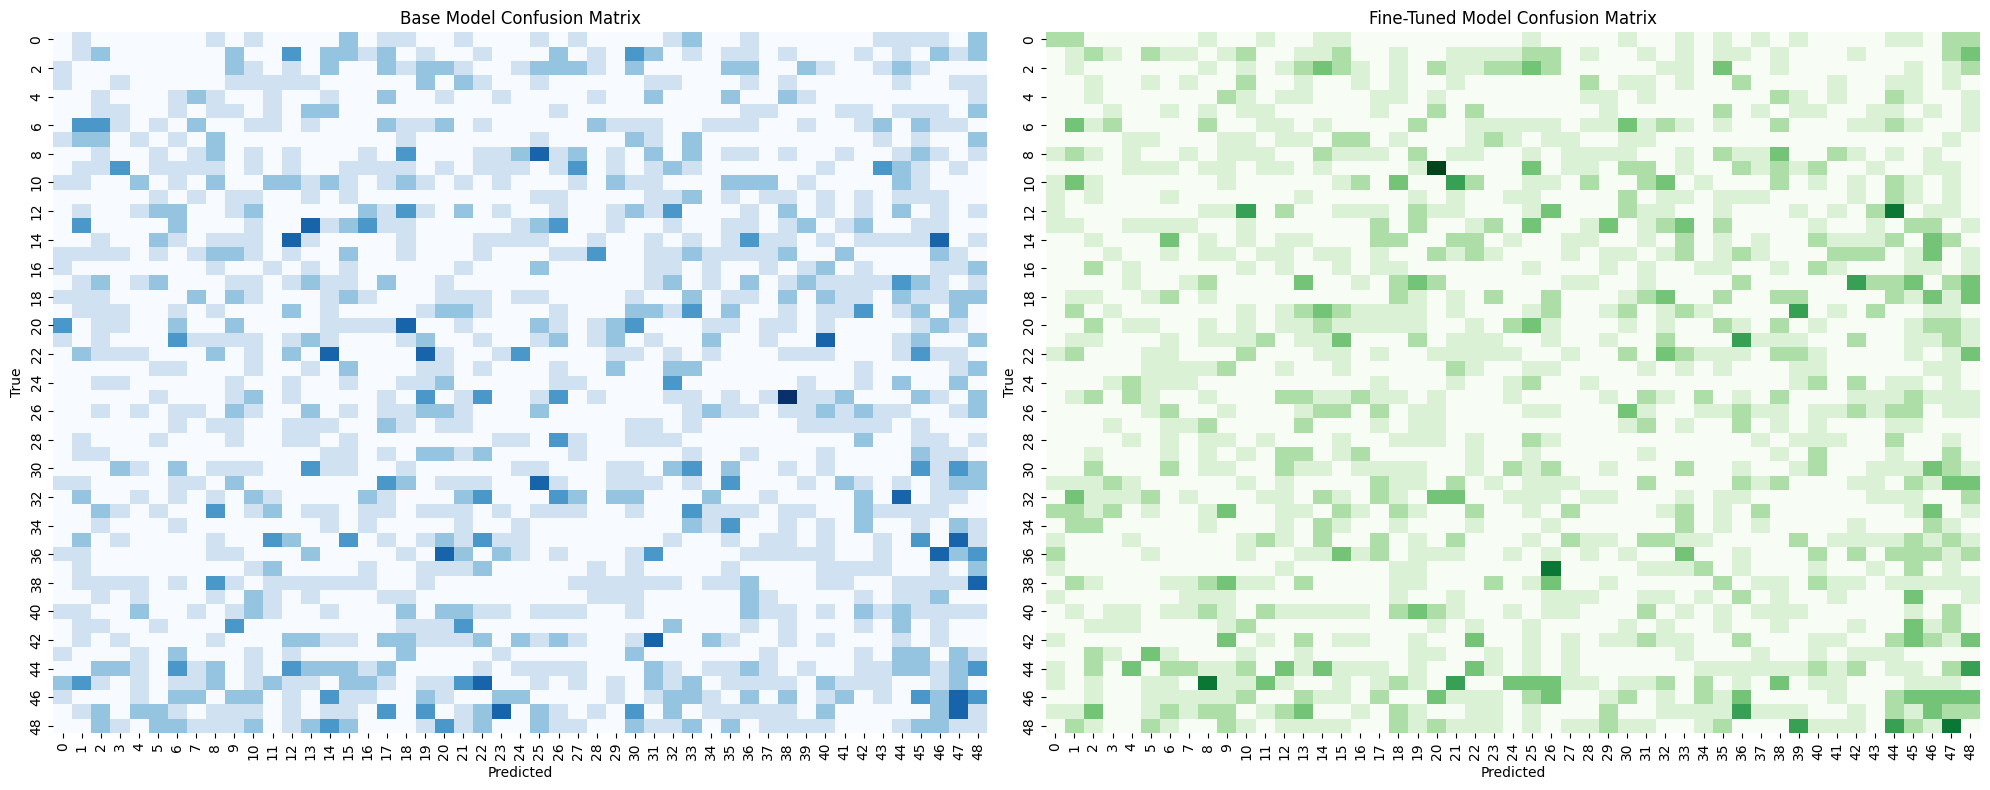

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
# =========================================================
# Confusion Matrix Comparison (Heatmaps)
# =========================================================
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(confusion_matrix(y_true, y_pred_base), ax=axes[0], cmap="Blues", cbar=False)
axes[0].set_title("Base Model Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(confusion_matrix(y_true, y_pred_fine), ax=axes[1], cmap="Greens", cbar=False)
axes[1].set_title("Fine-Tuned Model Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()
